# Project 3 - Part 2 - Reddit Data Cleaning & EDA

This notebook will focus on data cleaning, exploratory data analysis (EDA) and natural language processing (NLP) on Anticonsumption and Minimalism subreddits we have scraped via Reddit API in Part - 1 notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import wordcloud
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS

from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
# Data from respective subreddits

anticon1_df = pd.read_csv('./csv_folder/anticonsumption_2019-10-12-19-40-11.csv')
anticon2_df = pd.read_csv('./csv_folder/anticonsumption_2019-10-13-18-48-20.csv')
anticon3_df = pd.read_csv('./csv_folder/anticonsumption_2019-10-14-17-15-18.csv')
anticon4_df = pd.read_csv('./csv_folder/anticonsumption_2019-10-15-16-07-26.csv')
anticon5_df = pd.read_csv('./csv_folder/anticonsumption_2019-10-16-03-37-26.csv')
anticon6_df = pd.read_csv('./csv_folder/anticonsumption_2019-10-17-05-56-48.csv')

minimal1_df = pd.read_csv('./csv_folder/minimalism_2019-10-12-19-40-11.csv')
minimal2_df = pd.read_csv('./csv_folder/minimalism_2019-10-13-18-48-20.csv')
minimal3_df = pd.read_csv('./csv_folder/minimalism_2019-10-14-17-15-18.csv')
minimal4_df = pd.read_csv('./csv_folder/minimalism_2019-10-15-16-07-27.csv')
minimal5_df = pd.read_csv('./csv_folder/minimalism_2019-10-16-03-37-27.csv')
minimal6_df = pd.read_csv('./csv_folder/minimalism_2019-10-17-05-56-48.csv')

In [3]:
anticon_df = pd.concat([anticon1_df, anticon2_df, anticon3_df, anticon4_df, anticon5_df, anticon6_df])
anticon_df = anticon_df.drop_duplicates().reset_index(drop=True)

In [4]:
minimal_df = pd.concat([minimal1_df, minimal2_df, minimal3_df, minimal4_df, minimal5_df, minimal6_df])
minimal_df = minimal_df.drop_duplicates().reset_index(drop=True)

In [5]:
anticon_df.head()

,subreddit,title,body,created,total_comments,total_upvotes
0,Anticonsumption,Great idea,NaN,2019-10-12 19:26:23,0,3
1,Anticonsumption,Erik put a straw through his sippy cup. Dont' ...,NaN,2019-10-12 17:23:52,5,1
2,Anticonsumption,"Why, just why?",NaN,2019-10-12 17:13:44,0,0
3,Anticonsumption,Local pho shop smooths edges of chipped bowls ...,NaN,2019-10-12 15:34:28,7,166
4,Anticonsumption,Have to agree.,NaN,2019-10-12 13:44:49,1,39


In [6]:
minimal_df.head()

,subreddit,title,body,created,total_comments,total_upvotes
0,minimalism,Book Recommendations,"Hey all, I’m new to the whole minimalism thing...",2019-10-12 12:14:26,21,60
1,minimalism,"WeeklyThread | Screenshot Saturday October 12,...",Got a new style for your home screen? Or maybe...,2019-10-12 09:32:37,1,1
2,minimalism,Purging unused hobby gear,"I have a road bike, a mountain bike, scuba gea...",2019-10-12 08:49:59,12,20
3,minimalism,Do collections as a hobby really add much valu...,I understand if you really like say for exampl...,2019-10-11 21:20:16,62,131
4,minimalism,Minimalist Clothing Brand,I'm developing a clothing brand for minimalist...,2019-10-11 12:40:13,15,0


In [7]:
anticon_df.shape

(3696, 6)

In [8]:
minimal_df.shape

(3313, 6)

In [9]:
anticon_df['body'].isnull().sum()

3201

In [10]:
minimal_df['body'].isnull().sum()

132

In [11]:
# Let's consider "anticonsumption" is the target value since it represents the majority class
anticon_df['target'] = 1

In [12]:
minimal_df['target'] = 0

In [13]:
combined_subs_df = pd.concat([anticon_df, minimal_df])
combined_subs_df.shape

(7009, 7)

In [14]:
combined_subs_df['target'].value_counts(normalize=True)

1    0.527322
0    0.472678
Name: target, dtype: float64

The classes are perfectly balanced, good to go.

In [15]:
# Built-in function to drop duplicate rows
combined_subs_df = combined_subs_df.drop_duplicates()

# Resetting index
combined_subs_df = combined_subs_df.reset_index(drop=True)

combined_subs_df.shape

(7009, 7)

In [16]:
combined_subs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7009 entries, 0 to 7008
Data columns (total 7 columns):
subreddit         7009 non-null object
title             7009 non-null object
body              3676 non-null object
created           7009 non-null object
total_comments    7009 non-null int64
total_upvotes     7009 non-null int64
target            7009 non-null int64
dtypes: int64(3), object(4)
memory usage: 383.4+ KB


In [17]:
combined_subs_df.describe()

,total_comments,total_upvotes,target
count,7009.000000,7009.000000,7009.000000
mean,26.307747,230.128977,0.527322
std,45.459945,566.463256,0.499289
min,0.000000,0.000000,0.000000
25%,4.000000,9.000000,0.000000
50%,11.000000,30.000000,1.000000
75%,29.000000,152.000000,1.000000
max,600.000000,6718.000000,1.000000


I scraped both Title and Body texts in two separate columns. However, there are 3201 nulls out of 3696 posts in Anticonsumption subreddit which means the users prefer entering the text only in Title section. Even though Minimalism subreddit have very few null values, I can't compare body text since they are not equally distributed in both subreddits. I will only add Title as a feature and based on the most common words outcome, I will decide if I need to incorparate the top level comments as well.

In [18]:
# Create a new column that counts words in 'title' column
combined_subs_df['num_title_words'] = combined_subs_df['title'].apply(lambda x: len(x.split()))

In [19]:
# Create a new column that counts words in 'title' column
combined_subs_df['num_title_chars'] = combined_subs_df['title'].apply(len)

In [20]:
combined_subs_df.head()

,subreddit,title,body,created,total_comments,total_upvotes,target,num_title_words,num_title_chars
0,Anticonsumption,Great idea,NaN,2019-10-12 19:26:23,0,3,1,2,10
1,Anticonsumption,Erik put a straw through his sippy cup. Dont' ...,NaN,2019-10-12 17:23:52,5,1,1,12,59
2,Anticonsumption,"Why, just why?",NaN,2019-10-12 17:13:44,0,0,1,3,14
3,Anticonsumption,Local pho shop smooths edges of chipped bowls ...,NaN,2019-10-12 15:34:28,7,166,1,12,67
4,Anticonsumption,Have to agree.,NaN,2019-10-12 13:44:49,1,39,1,3,14


In [21]:
# Look at class distributions
combined_subs_df['target'].value_counts(normalize=True)

1    0.527322
0    0.472678
Name: target, dtype: float64

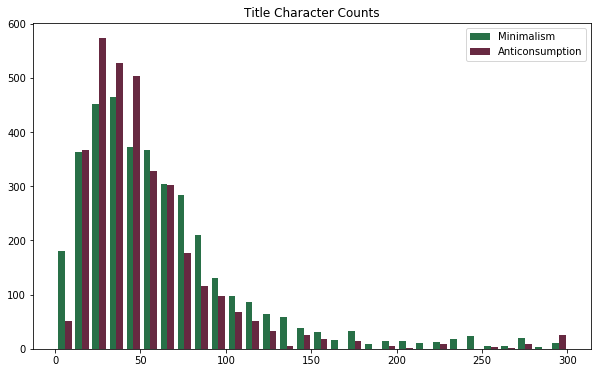

In [22]:
# Plot a histogram of character counts
minimal_mask = (combined_subs_df['target'] == 1)
plt.figure(figsize=[10,6])
plt.hist(
    [combined_subs_df[minimal_mask]['num_title_chars'], combined_subs_df[~minimal_mask]['num_title_chars']],
    bins = 30, color=['#287047', '#672941']
        )

plt.title('Title Character Counts')
plt.legend(['Minimalism', 'Anticonsumption']);

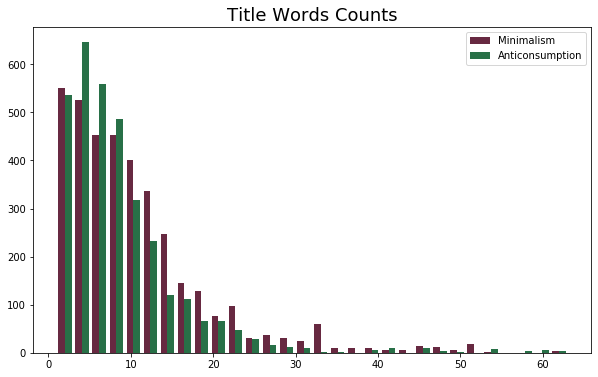

In [23]:
# Plot a histogram of character counts
minimal_mask = (combined_subs_df['target'] == 1)
plt.figure(figsize=[10,6])
plt.hist(
    [combined_subs_df[minimal_mask]['num_title_words'], combined_subs_df[~minimal_mask]['num_title_words']],
    bins = 30, color=['#672941', '#287047']
        )

plt.title('Title Words Counts', fontsize=18)
plt.legend(['Minimalism', 'Anticonsumption']);

Average number of character are 57 and average number of words are 10. We are not dealing with too many words here and hopefully they are some useful keywords that help to identify my subreddits.

In [24]:
combined_subs_df.describe()

,total_comments,total_upvotes,target,num_title_words,num_title_chars
count,7009.000000,7009.000000,7009.000000,7009.000000,7009.000000
mean,26.307747,230.128977,0.527322,10.091311,58.270795
std,45.459945,566.463256,0.499289,8.386851,46.523899
min,0.000000,0.000000,0.000000,1.000000,1.000000
25%,4.000000,9.000000,0.000000,5.000000,28.000000
50%,11.000000,30.000000,1.000000,8.000000,47.000000
75%,29.000000,152.000000,1.000000,13.000000,74.000000
max,600.000000,6718.000000,1.000000,63.000000,300.000000


- #### Word Cloud for 'Title'

Before vectorizing title words, I will create word clouds for each subredit title to have a quick insight on identifying frequent words. Hopefully, the result will not be too dissapointing that I may want to question my subreddit selections.  

Since the wordcloud library is looking for raw text as the input, I will use my raw, organic, untouched 'title' column.

- #### Count Vectorizer

I will use CountVectorizer to quantify the text by counting the number of unique words in each observation. Then, turn each observation into a vector  and store in dataframe.

In [25]:
X = combined_subs_df['title']
y = combined_subs_df['target']

In [26]:
custom_stop = list(ENGLISH_STOP_WORDS)
custom_stop.extend(['minimalism', 'minimalist', 'minimal', 'anticonsumption', 'consumption', 'life', 'good',
                    'target', 'reddit', 'subreddit', 'http', 'www', '000', '10', '100', '11', '20', '2019', '24', '30'])

In [27]:
cvec = CountVectorizer(stop_words=custom_stop, ngram_range=(1,2), min_df = 5, max_df = .90)

title_df = pd.DataFrame(
    cvec.fit_transform(X).todense(),
    columns=cvec.get_feature_names()
)

title_df.head()

,01,02,04,04 17,05,09,104,104 weeks,114,114 hangers,...,young climate,youtube,youtube time,youtube videos,youtuber,youtuber pretentious,zero,zero waste,zerowaste,zerowaste responsible
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Create sub dataframes for each subreddit.

In [28]:
# add target column to title words dataframe
title_df['target'] = y
# title_df.insert(loc=-1, column='target', value=y)

In [29]:
anticon = title_df[title_df['target'] == 1].copy()
minimal = title_df[title_df['target'] == 0].copy()

Check most frequent words in both subreddits.

In [30]:
title_df.iloc[:, :-1].sum().sort_values(ascending=False).head(15)

plastic    304
just       301
new        214
things     212
buy        211
like       206
don        202
people     182
buying     161
use        150
want       144
stuff      138
time       130
make       124
waste      123
dtype: int64

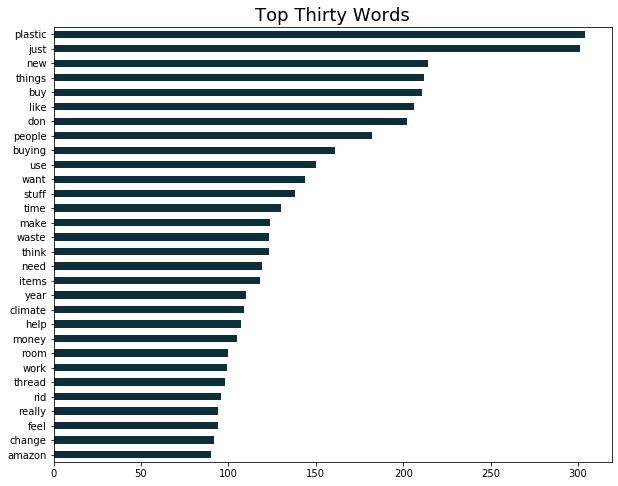

In [31]:
top_30 = title_df.iloc[:, :-1].sum().sort_values(ascending=True).tail(30)
plt.title('Top Thirty Words', fontsize=18)
top_30.plot.barh(color='#0C2F39', figsize= (10,8));

In [32]:
top_30_list = list(top_30.index)

In [33]:
print(top_30_list)

['amazon', 'change', 'feel', 'really', 'rid', 'thread', 'work', 'room', 'money', 'help', 'climate', 'year', 'items', 'need', 'think', 'waste', 'make', 'time', 'stuff', 'want', 'use', 'buying', 'people', 'don', 'like', 'buy', 'things', 'new', 'just', 'plastic']


Top 30 most frequent words broken down by subreddit

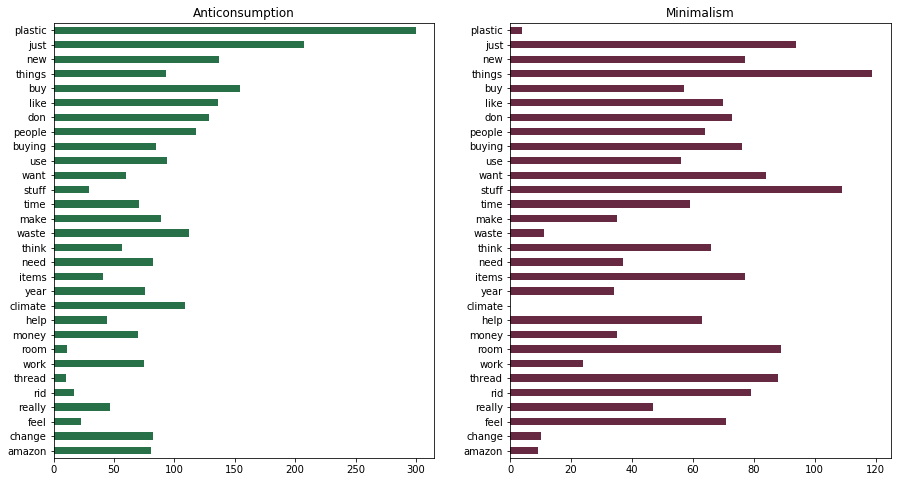

In [34]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (15,8))

anticon[top_30_list].sum().plot.barh(ax=ax1, color='#287047', title=('Anticonsumption'))
minimal[top_30_list].sum().plot.barh(ax=ax2, color='#672941', title=('Minimalism'));

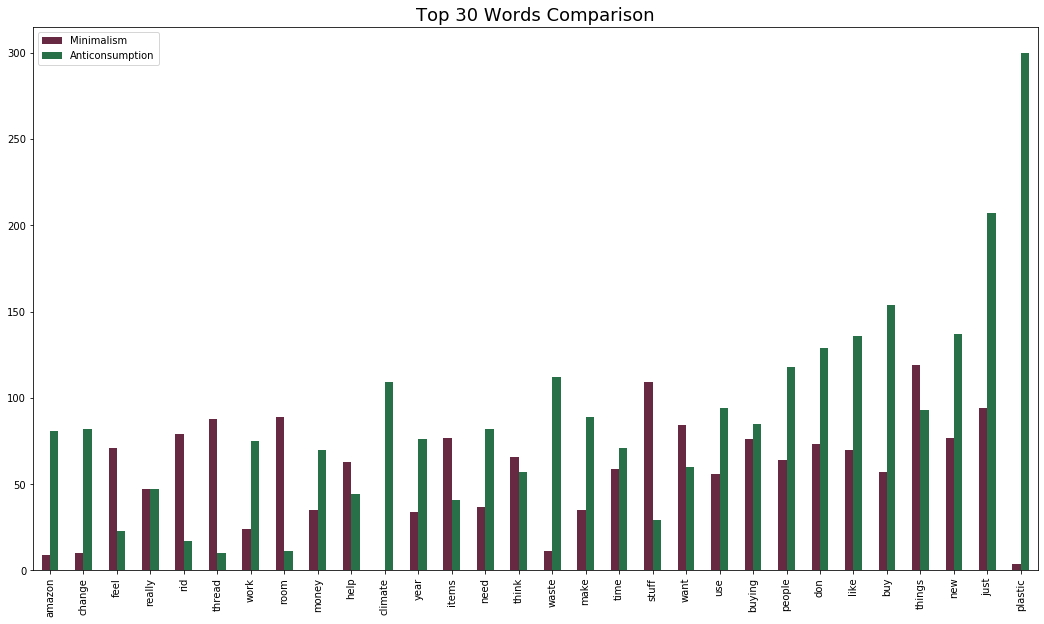

In [35]:
fig, ax = plt.subplots(figsize = (18, 10))
plt.title('Top 30 Words Comparison', fontsize=18)

title_df.groupby('target').sum()[top_30_list].T.plot.bar(ax=ax, color=['#672941', '#287047']);
plt.legend(['Minimalism', 'Anticonsumption']);

#### Top Words vs Class Correlation

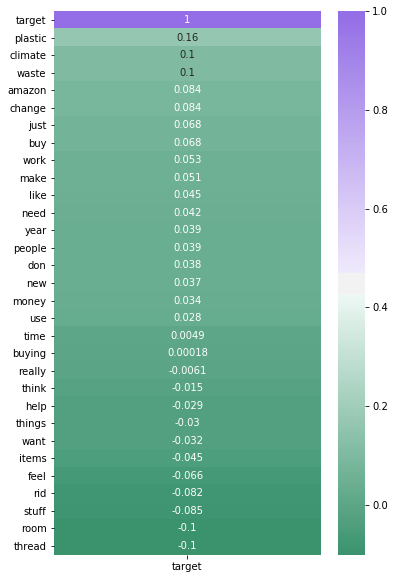

In [36]:
# Create a heatmap of correlations

corr = title_df[top_30_list].join(title_df['target']).corr()[['target']].sort_values('target', ascending=False)
plt.figure(figsize=(6,10))
cmap = sns.diverging_palette(150, 275, s=80, l=55, n=9, as_cmap=True)
sns.heatmap(corr, annot=True, cmap=cmap);

In [37]:
# Most positively correlated 50 words
title_df.corr()[['target']].sort_values('target', ascending=False).head(50).T

,target,plastic,climate,waste,world,water,individually,wrapped,packaging,amazon,...,problem,ad,products,fossil fuel,fuel,literally,bottle,packed,apple,today
target,1.0,0.163703,0.10297,0.102595,0.096071,0.095092,0.094404,0.09432,0.085729,0.084194,...,0.054909,0.054565,0.054363,0.054324,0.054324,0.054324,0.054324,0.054324,0.054263,0.054025


In [38]:
# Most negatively correlated 50 words
title_df.corr()[['target']].sort_values('target', ascending=False).tail(50).T

,tips,september,thoughts,clothes,social,getting,minimalists,kitchen,collection,recommendations,...,monday,thread room,lifestyle,decluttering,clutter,room,thread,minimalistic,weekly,weekly thread
target,-0.058596,-0.058771,-0.059791,-0.060629,-0.061404,-0.061781,-0.061912,-0.061912,-0.061912,-0.062663,...,-0.09564,-0.09564,-0.095703,-0.096482,-0.099645,-0.100564,-0.101437,-0.105317,-0.1191,-0.1191


#### Word Counts

Characters per sentence per subreddit.

In [39]:
title_df['num_title_words'] = X.apply(lambda x: len(x.split(' ')))
title_df.head()

,01,02,04,04 17,05,09,104,104 weeks,114,114 hangers,...,youtube time,youtube videos,youtuber,youtuber pretentious,zero,zero waste,zerowaste,zerowaste responsible,target,num_title_words
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,12
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,12
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3


In [40]:
anticon_counts = title_df[title_df['target'] == 1]['num_title_words']
minimal_counts = title_df[title_df['target'] == 0]['num_title_words']

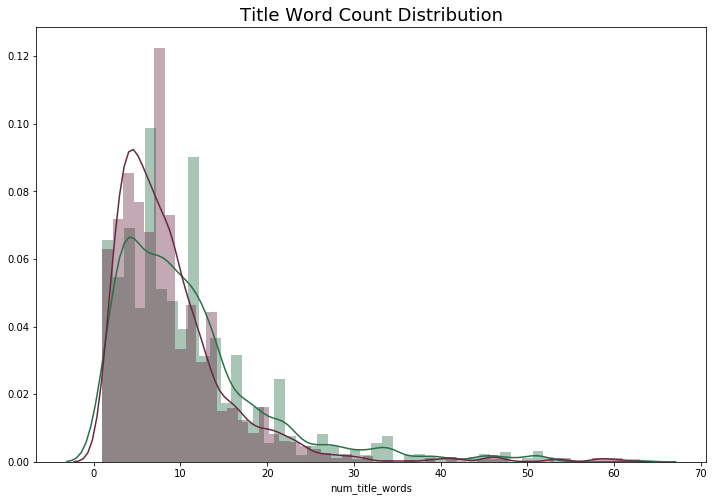

In [41]:
fig, ax = plt.subplots(figsize = (12,8))
plt.title('Title Word Count Distribution', fontsize=18)
sns.distplot(anticon_counts, ax=ax, color='#287047')
sns.distplot(minimal_counts, ax=ax, color='#672941');

### Sentiment Analysis

In [42]:
# instantiate the sentiment analyzer
sia = SentimentIntensityAnalyzer()

In [43]:
# Write a function to get the compound sentiment scores for a post
def get_compound(text):
    return sia.polarity_scores(text)['compound']

In [44]:
# apply the function to the entire subreddit dataframe
combined_subs_df['sentiment'] = combined_subs_df['title'].apply(get_compound)

In [45]:
# look at the distribution of the composite sentiment score
combined_subs_df.groupby('target')['sentiment'].mean()

target
0    0.067949
1    0.005940
Name: sentiment, dtype: float64

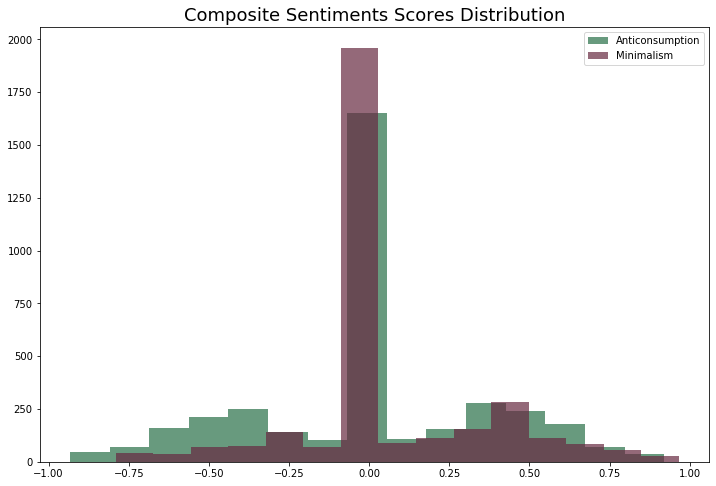

In [46]:
# Composite sentiment score histogram
fig, ax = plt.subplots(figsize = (12, 8))
plt.title('Composite Sentiments Scores Distribution', fontsize=18)

combined_subs_df[combined_subs_df['target']==1]['sentiment'].hist(ax=ax, color='#287047', label='Anticonsumption', 
                                                                  bins=15, alpha=0.7, grid=False)
combined_subs_df[combined_subs_df['target']==0]['sentiment'].hist(ax=ax, color='#672941', label='Minimalism', 
                                                                  bins=15, alpha=0.7, grid=False)
ax.legend(loc='best');

In [47]:
# check correlation
combined_subs_df['sentiment'].corr(combined_subs_df['target'])

-0.09537146782753166

#### Upvotes Count

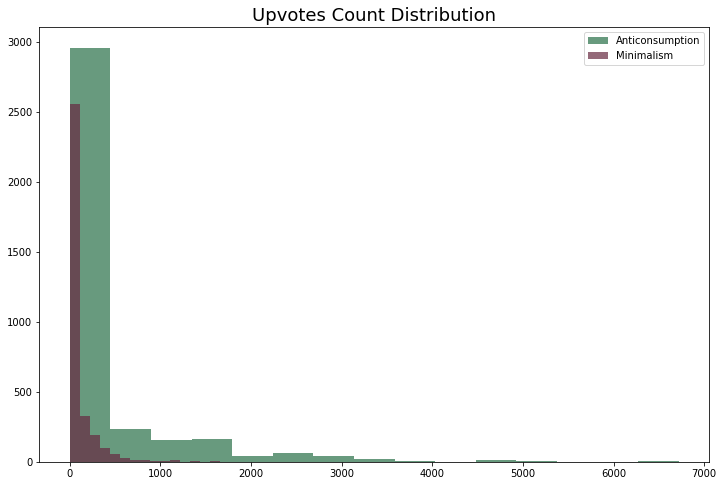

In [48]:
# Composite sentiment score histogram
fig, ax = plt.subplots(figsize = (12, 8))
plt.title('Upvotes Count Distribution', fontsize=18)

combined_subs_df[combined_subs_df['target']==1]['total_upvotes'].hist(ax=ax, color='#287047', label='Anticonsumption', 
                                                                  bins=15, alpha=0.7, grid=False)
combined_subs_df[combined_subs_df['target']==0]['total_upvotes'].hist(ax=ax, color='#672941', label='Minimalism', 
                                                                  bins=15, alpha=0.7, grid=False)
ax.legend(loc='best');

In [49]:
# check correlation
combined_subs_df['total_upvotes'].corr(combined_subs_df['target'])

0.23316226320187347

#### Comments Count

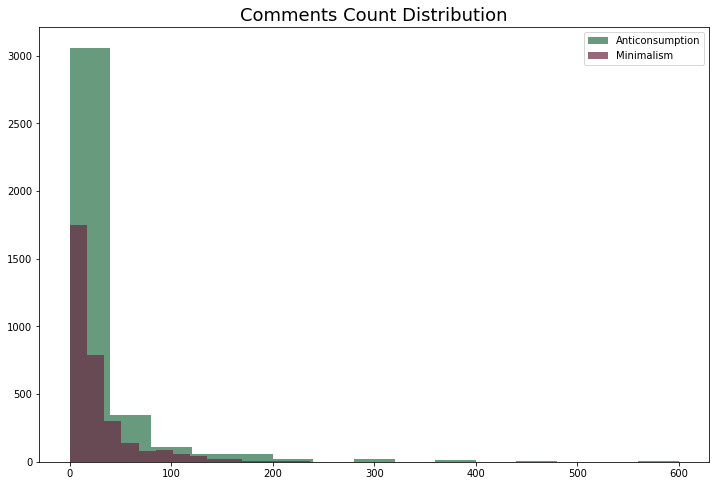

In [50]:
# Composite sentiment score histogram
fig, ax = plt.subplots(figsize = (12, 8))
plt.title('Comments Count Distribution', fontsize=18)

combined_subs_df[combined_subs_df['target']==1]['total_comments'].hist(ax=ax, color='#287047', label='Anticonsumption', 
                                                                  bins=15, alpha=0.7, grid=False)
combined_subs_df[combined_subs_df['target']==0]['total_comments'].hist(ax=ax, color='#672941', label='Minimalism', 
                                                                  bins=15, alpha=0.7, grid=False)
ax.legend(loc='best');

In [51]:
combined_subs_df['total_comments'].corr(combined_subs_df['target'])

-0.019541908200513988

- #### Export the data

In [52]:
combined_subs_df.fillna('thisisablankpost', inplace=True)

In [53]:
combined_subs_df.to_csv('./csv_folder/combined_subreddits.csv', index=False)